# Word2Vec 예제 구현
Word2Vec 모델을 구현해본다.

In [1]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
font_name = matplotlib.font_manager.FontProperties(
                        fname="/Library/Fonts/NanumGothic.ttf").get_name()
print(font_name)
matplotlib.rc('font', family="NanumGothic")

NanumGothic


In [4]:
sentences = ["나 고양이 좋다",
             "나 강아지 좋다",
             "나 동물 좋다",
             "강아지 고양이 동물",
             "여자친구 고양이 강아지 좋다",
             "고양이 생선 우유 좋다",
             "강아지 생선 싫다 우유 좋다",
             "강아지 고양이 눈 좋다",
             "나 여자친구 좋다",
             "여자친구 나 싫다",
             "여자친구 나 영화 책 음악 좋다",
             "나 게임 만화 애니 좋다",
             "고양이 강아지 싫다",
             "강아지 고양이 좋다"]

In [5]:
word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))

문장을 전부 합친 후에 공백으로 단어들을 나누고 이를 바탕으로 리스트를 만든다.

In [6]:
word_dict = {w: i for i, w in enumerate(word_list)}

문자열 자체보다는 숫자로 분석하는 것이 훨씬 용이하므로, 리스트에서 문자들의 인덱스를 뽑아서 사용하고 위해 인덱스 배열을 만든다.

In [7]:
skip_grams = []

for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i-1]], word_dict[word_sequence[i+1]]]
    
    for w in context:
        skip_grams.append([target,w])

윈도우 사이즈를 1로 하는 Skip-gram 모델을 만든다.  
스킵그램을 만든 후, 저장은 단어의 index를 통해 저장한다.
# Skip-Gram Model 이란?
만약 다음과 같은 문장이 있다고 가정하자.  

> _**the quick brown fox jumped over the lazy dog.**_  

여기서는 간단하게 Context를 현재(목표) 단어의 왼쪽과 오른쪽에 있는 단어들의 윈도우로 정의한다.  
윈도우 사이즈를 1로 하면 (context, target) 쌍으로 구성된 다음과 같은 데이터셋을 얻을 수 있다.  

>\\(([the, brown], quick), ([quick, fox], brown), ([brown,jumped],fox), ...\\)  

우리가 만약 'quick'으로부터 Context 'the' 와 'brown' 을 예측해야 한다면, 다음의 데이터셋이 활용된다.  

>\\((quick, the), (quick, brown), (brown, quick), (brown, fox), ...\\)  


### Ex) Windows가 2일 경우
![Image](https://i.imgur.com/8zNRwsn.png)

목적 함수는 성능상의 이유로 보통 Stochastic Gradient Descent Descent(SGD) 알고리즘을 사용해서   
하나 또는 minibatch 라고 부르는 일정 개수의 데이터(배치)로 묶어서 최적화한다.   
일반적으로 데이터 개수는 16 ~ 512 이다.

In [8]:
def random_batch(data,size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)
    
    for i in random_index:
        random_inputs.append(data[i][0])
        random_labels.append([data[i][1]])
        
    return random_inputs, random_labels

### Learning Option Setting

In [9]:
training_epoch = 300
learning_rate = 0.1
batch_size = 20
embedding_size = 2
num_sampled = 15
voc_size = len(word_list)

- training_epoch : 학습을 반복할 횟수
- learning_rate = 학습률(Gradient Descent의 정도)
- batch_size = 한번에 학습할 데이터의 크기
- embedding_size = 단어 벡터를 구성할 Dimension 크기
- num_sampled = word2vec 모델을 학습하는 nce_loss 함수에서 사용하는 샘플링의 크기  
(batch_size 보다 작아야 한다.)
- voc_size = 총 단어의 갯수

### Neural Network Model Construction

In [10]:
inputs = tf.placeholder(tf.int32, shape=[batch_size])
labels = tf.placeholder(tf.int32, shape=[batch_size , 1])

tf.nn.nce_loss를 사용하기 위해서 [batch_size, 1] 꼴로 구성을 한다.
# NCE(Noise-Contrastive Estimation)이란?
CBOW와 Skip-Gram 모델에서 사용하는 Cost 알고리즘이다. 전체 데이터셋에 대해 SoftMax 함수를 적용하는 것이 아니라 샘플링으류 추출한 일부에 대해서만 적용하는 방법을 말한다. K개의 대비되는(Contrastive) 단어들을 noise distribution에서 구해서 Monte Carlo 평균을 구하는 것이 기본 알고리즘이다.  
일반적으로 단어 갯수가 많을 때 사용하고, NCE를 사용하면 문제를 실제 데이터에서 얻은 샘플과 인공적으로 만든 잡음 분포에서 얻은 샘플을 구별하는 이진 분류 문제로 바꿀 수 있게 된다.
모든 단어에 대해서 Softmax을 계산하고 Normalization을 하기엔 너무 오래걸리므로 Negative Sampling, Hierachical Softmax등의 방법을 사용한다.
## Negative Sampling ( tf.nn.nce_loss )
Negative Sampling에서 사용하는 목적 함수는 결과값이 최대화될 수 있는 형태로 구성된다. 현재(목표, target, positive) 단어에는 높은 확률을 부여하고, 나머지 단어(negative, noise)에는 낮은 확률을 부여해서 가장 큰 값을 만들 수 있는 공식을 사용한다. 특히 Cost에서 전체 단어 V를 계산하는 것이 아니라 선택한 k개의 noise 단어들만 계산하면 되기 때문에 효율적이다. 텐서플로우에서는 tf.nn.nce_loss()로 구현되어 있다. 

In [11]:
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))

Word2Vec 모델의 결과 값인 임베딩 벡터를 저장할 변수를 선언하고, 총 단어 개수와 임베딩 개수를 크기로 하는 두 개의 차원으로 설정한다.

In [12]:
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

임베딩 벡터의 차원에서 학습할 입력값에 대한 행들을 뽑아온다.  
embedd     &nbsp;&nbsp;inputs  &nbsp;&nbsp;  selected  
    [1, 2, 3]  -> [2, 3] -> [2, 3, 4]  
    [2, 3, 4]&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  [3, 4, 5]  
    [3, 4, 5]  
    [4, 5, 6]

In [13]:
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

loss = tf.reduce_mean(
                tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

GradientDescent가 아닌 AdamOptimizer를 사용한다.  
별도의 작업은 필요없고, 그냥 함수이름만 다르게 쓰면 된다.  
Adam은 현존하는 알고리즘 중에서 가장 강력한 성능을 보여주는 최적화 알고리즘이라고 한다.

### Neural Network Model Learning

In [14]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)
        _, loss_val = sess.run([train_op, loss],
                                          feed_dict={inputs: batch_inputs,
                                                            labels: batch_labels})
        if step % 10 == 0:
            print("loss at step ", step, ": ", loss_val)
    
    trained_embeddings = embeddings.eval()

loss at step  10 :  5.203868
loss at step  20 :  3.5246475
loss at step  30 :  3.7621956
loss at step  40 :  3.1559167
loss at step  50 :  3.433635
loss at step  60 :  3.4259632
loss at step  70 :  3.4869142
loss at step  80 :  3.2576058
loss at step  90 :  3.0651166
loss at step  100 :  3.124257
loss at step  110 :  3.3450248
loss at step  120 :  3.3538356
loss at step  130 :  3.5285785
loss at step  140 :  3.3762956
loss at step  150 :  3.260347
loss at step  160 :  3.2661934
loss at step  170 :  3.118836
loss at step  180 :  3.2403705
loss at step  190 :  2.8177452
loss at step  200 :  2.9476116
loss at step  210 :  3.3562312
loss at step  220 :  3.3118114
loss at step  230 :  2.8114314
loss at step  240 :  3.170344
loss at step  250 :  3.353152
loss at step  260 :  3.0314388
loss at step  270 :  3.4905643
loss at step  280 :  3.1049454
loss at step  290 :  3.193821
loss at step  300 :  3.3837783


### 임베딩 된 Word2Vec 결과 확인

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


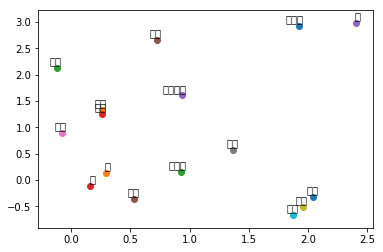

In [15]:
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x,y)
    plt.annotate(label, xy=(x,y), xytext=(5,2),
                         textcoords='offset points', ha='right', va='bottom')

plt.show()